<a href="https://colab.research.google.com/github/tcharos/Human-Activity-Recognition-Using-Smartphones/blob/main/human_activity_recognityion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIDL_B_AS01 - Signal Processing, Pattern Recognition and Machine Learning

## Human Activity Recognition Using Smartphones

**Dataset:** https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

---
1. DATA INSPECTION AND ACQUISITION
---

In [1]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
import os

import random
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "./data_set/UCI HAR Dataset/"

SIGNAL_FILES = [
    "body_acc_x",
    "total_acc_x",
    "body_gyro_x" # cant find exact match "body_gyro_acc_x"
]

ACTIVITY_NAMES = {
    1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 5: 'STANDING', 6: 'LYING'
}

In [3]:
def load_signals(data_path, dataset_type, signal_files):
    """
    data_path (str): The base path to the data directory.
    dataset_type (str): 'train' or 'test'.
    signal_files (list): List of base names for the signal files (e.g., 'body_acc_x')

    dict: A dictionary where keys are signal names and values are NumPy arrays of shape (N_instances, 128)
    """
    signals = {}
    
    # Path to the Inertial Signals folder
    signals_dir = os.path.join(data_path, dataset_type, 'Inertial Signals')
    
    print(f"--- Loading {dataset_type.upper()} Signals from: {signals_dir} ---")
    
    for signal_name in signal_files:
        # Construct the full filename
        filename = f"{signal_name}_{dataset_type}.txt"
        file_path = os.path.join(signals_dir, filename)
        
        try:
            data_matrix = np.loadtxt(file_path, dtype=np.float32)
            signals[signal_name] = data_matrix
            print(f"Loaded {filename}: Shape {data_matrix.shape}")
        except FileNotFoundError:
            print(f"ERROR: File not found at {file_path}. Skipping.")
        
    return signals


def load_labels(data_path, dataset_type):
    
    labels_dir = os.path.join(data_path, dataset_type)
    filename = f"y_{dataset_type}.txt"
    file_path = os.path.join(labels_dir, filename)
    
    try:
        # Labels are single integers per line
        labels = np.loadtxt(file_path, dtype=np.int32)
        print(f"Loaded {filename}: Shape {labels.shape}")
        return labels
    except FileNotFoundError:
        print(f"ERROR: Label file not found at {file_path}. Cannot proceed.")
        return None

In [4]:
# Load Train Data and Labels
train_signals = load_signals(DATA_PATH, 'train', SIGNAL_FILES)
train_labels = load_labels(DATA_PATH, 'train')

# Load Test Data and Labels
test_signals = load_signals(DATA_PATH, 'test', SIGNAL_FILES)
test_labels = load_labels(DATA_PATH, 'test')

if all(s in train_signals for s in SIGNAL_FILES) and train_labels is not None:
    expected_train_shape = (7352, 128) # from pdf
    first_signal_key = SIGNAL_FILES[0]
    
    if train_signals[first_signal_key].shape == expected_train_shape:
        print("\nTraining data dimensions verified successfully!")
    else:
        print(f"\nWARNING: Expected training signal shape {expected_train_shape}, but got {train_signals[first_signal_key].shape}")

--- Loading TRAIN Signals from: ./data_set/UCI HAR Dataset/train/Inertial Signals ---
Loaded body_acc_x_train.txt: Shape (7352, 128)
Loaded total_acc_x_train.txt: Shape (7352, 128)
Loaded body_gyro_x_train.txt: Shape (7352, 128)
Loaded y_train.txt: Shape (7352,)
--- Loading TEST Signals from: ./data_set/UCI HAR Dataset/test/Inertial Signals ---
Loaded body_acc_x_test.txt: Shape (2947, 128)
Loaded total_acc_x_test.txt: Shape (2947, 128)
Loaded body_gyro_x_test.txt: Shape (2947, 128)
Loaded y_test.txt: Shape (2947,)

Training data dimensions verified successfully!


In [5]:
# Data visualization and exploration

sensor_key = 'body_acc_x'
data_to_plot = train_signals[sensor_key]
sample_indices = {}

for label_code in range(1, 7):
    index = np.where(train_labels == label_code)[0][0]
    sample_indices[label_code] = index

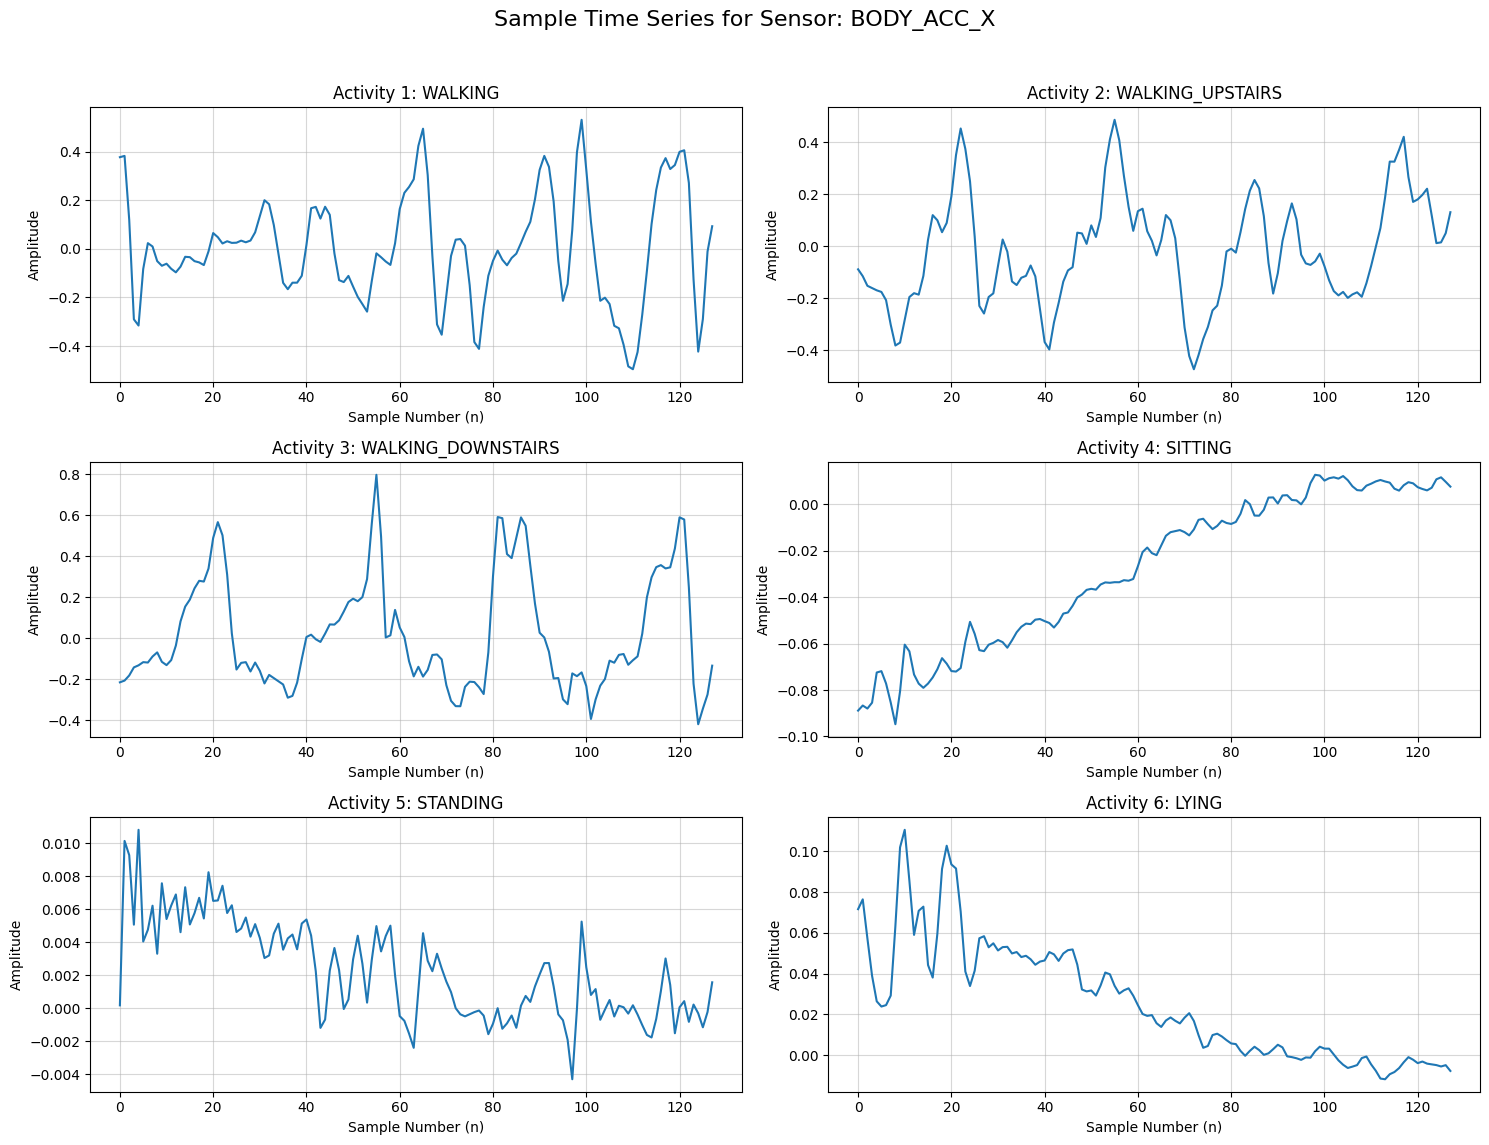

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Sample Time Series for Sensor: {sensor_key.upper()}', fontsize=16)
axes = axes.flatten()

time = np.arange(128) 

for i, (label_code, index) in enumerate(sample_indices.items()):
    signal_vector = data_to_plot[index, :]
    activity_name = ACTIVITY_NAMES[label_code]
    
    axes[i].plot(time, signal_vector, linewidth=1.5)
    axes[i].set_title(f'Activity {label_code}: {activity_name}')
    axes[i].set_xlabel('Sample Number (n)')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

---
2. YULE-WALKER LINEAR PREDICTION
---

In [7]:
# --- Functions for Yule-Walker ---

def calculate_autocorrelation(signal, p):
    """
    signal (np.array): The 1D input signal (zero-mean assumption)
    p (int): The maximum lag (order) to calculate for

    np.array: Autocorrelation vector r[0], r[1], ..., r[p]
    """
    N = len(signal)
    # Using 'full' mode and taking the positive lags provides a robust way
    # to estimate the autocorrelation. We normalize by N (biased estimate).
    r_full = np.correlate(signal, signal, mode='full') / N
    
    # Extract only the positive lags: r[0] is at index N-1, up to r[p]
    r = r_full[N-1 : N-1 + p + 1]
    return r

def solve_yule_walker(r, p):
    """
    r (np.array): Autocorrelation vector r[0] to r[p]
    p (int): The order of the predictor

   np.array: The LPC coefficients a = [a1, a2, ..., ap]
    """
    # Construct the R_p Toeplitz matrix (p x p)
    R = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            R[i, j] = r[np.abs(i - j)]

    # Construct the -r_p vector (p x 1)
    r_p = -r[1 : p + 1]

    # Solve the linear system R * a = r_p
    try:
        a_coeffs = np.linalg.solve(R, r_p)
    except np.linalg.LinAlgError:
        print("Warning: R matrix is singular. Using least-squares approximation.")
        a_coeffs = np.linalg.lstsq(R, r_p, rcond=None)[0]

    return a_coeffs

def calculate_prediction_error_and_signal(signal, a, p):
    """
    signal (np.array): The 1D input signal (length N)
    a (np.array): The LPC coefficients [a1, a2, ..., ap] (length p)
    p (int): The order of the predictor

    tuple: (Mean Squared Error (MSE), Predicted Signal Vector)
    """
    N = len(signal)
    predicted_signal = np.zeros(N)
    
    # Explicit indices for prediction: x_hat[n] = -sum_{k=1}^{p} a_k * x[n-k]
    for n in range(p, N):
        # The coefficients 'a' are [a1, a2, ..., ap].
        
        # We need the p previous samples: x[n-1], x[n-2], ..., x[n-p].
        # 1. Get the slice of p samples: signal[n-p] up to signal[n-1]
        #    This is the slice signal[n-p : n] (forward slice, length p).
        # 2. Reverse the slice to align with the coefficients: [::-1]
        #    This yields [x[n-1], x[n-2], ..., x[n-p]].
        past_samples = signal[n-p : n][::-1] 
        
        # Calculate the predicted sample
        prediction = -np.sum(a * past_samples)
        predicted_signal[n] = prediction
        
    # Calculate error (MSE) only on the predicted part (from index p to N)
    original_predicted_part = signal[p:]
    prediction_actual_part = predicted_signal[p:]
    
    error = original_predicted_part - prediction_actual_part
    mse = np.mean(error**2)
    
    return mse, predicted_signal

In [8]:
data_to_analyze = train_signals['body_acc_x']

N_SAMPLES = data_to_analyze.shape[1]

In [9]:
P_RANGE = range(2, 21, 2)
N_RANDOM_SAMPLES = 10
all_average_errors = {}
random_indices = random.sample(range(data_to_analyze.shape[0]), N_RANDOM_SAMPLES)

print("--- Step 1: Finding Optimal Predictor Order p ---")

for p in P_RANGE:
    current_p_errors = []
    
    for idx in random_indices:
        signal = data_to_analyze[idx, :]
        
        # coefficients
        r_coeffs = calculate_autocorrelation(signal, p)
        a_coeffs = solve_yule_walker(r_coeffs, p)
        
        # error
        mse, _ = calculate_prediction_error_and_signal(signal, a_coeffs, p)
        current_p_errors.append(mse)
        
    avg_error = np.mean(current_p_errors)
    all_average_errors[p] = avg_error
    print(f"Order p={p}: Average MSE = {avg_error:.6f}")

# find the best p
BEST_P = min(all_average_errors, key=all_average_errors.get)
MIN_AVG_ERROR = all_average_errors[BEST_P]

print(f"\nOptimal Predictor Order: BEST_P = {BEST_P}")
print(f"Minimum Average MSE: {MIN_AVG_ERROR:.6f}")

--- Step 1: Finding Optimal Predictor Order p ---
Order p=2: Average MSE = 0.002847
Order p=4: Average MSE = 0.002523
Order p=6: Average MSE = 0.002283
Order p=8: Average MSE = 0.002089
Order p=10: Average MSE = 0.001978
Order p=12: Average MSE = 0.001874
Order p=14: Average MSE = 0.001709
Order p=16: Average MSE = 0.001608
Order p=18: Average MSE = 0.001543
Order p=20: Average MSE = 0.001534

Optimal Predictor Order: BEST_P = 20
Minimum Average MSE: 0.001534


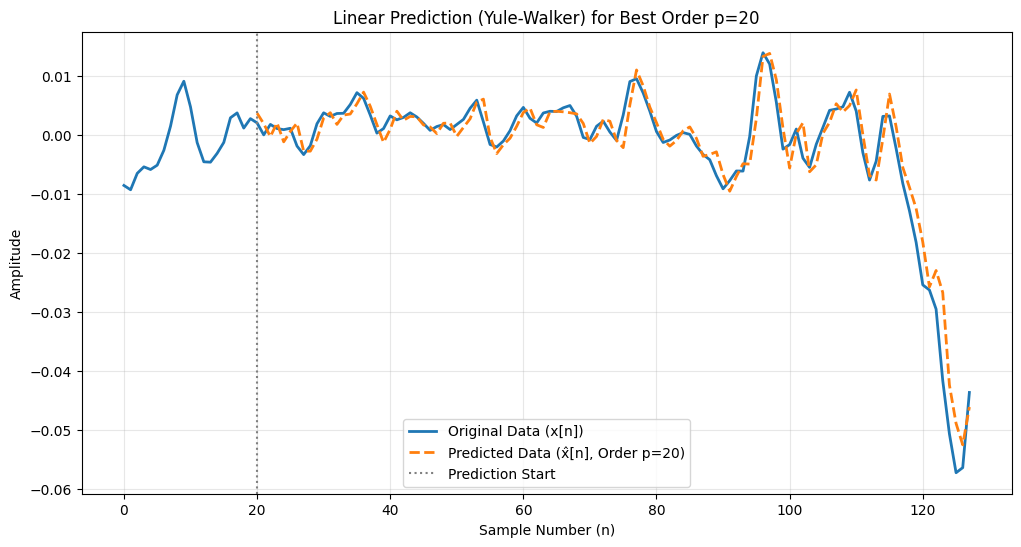

In [10]:
PLOT_INDEX = random_indices[0]
signal_to_plot = data_to_analyze[PLOT_INDEX, :]

# Recalculate coefficients and prediction for the best p
r_best = calculate_autocorrelation(signal_to_plot, BEST_P)
a_best = solve_yule_walker(r_best, BEST_P)
_, predicted_signal_best = calculate_prediction_error_and_signal(signal_to_plot, a_best, BEST_P)

plt.figure(figsize=(12, 6))
time_axis = np.arange(N_SAMPLES)
plt.plot(time_axis, signal_to_plot, label='Original Data (x[n])', color='C0', linewidth=2)
plt.plot(time_axis[BEST_P:], predicted_signal_best[BEST_P:], 
         label=f'Predicted Data (x̂[n], Order p={BEST_P})', color='C1', linestyle='--', linewidth=2)
plt.axvline(x=BEST_P, color='gray', linestyle=':', label='Prediction Start')

plt.title(f'Linear Prediction (Yule-Walker) for Best Order p={BEST_P}')
plt.xlabel('Sample Number (n)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
3. KNN ALGORITHM IMPLEMENTATION
---

In [11]:
# KNN classifier
 
def knn_classifier(X_train, y_train, X_test, k=3):
    """
    X_train (np.array): Training feature vectors (N_train, D_features)
    y_train (np.array): Training labels (N_train,)
    X_test (np.array): Testing feature vectors (N_test, D_features)
    k (int): Number of nearest neighbors to consider.

    np.array: Predicted labels for the test set (N_test,)
    """
    y_pred = []
    
    # Iterate instances in the test set
    for test_instance in X_test:
        distances = []
        
        # Calculate distance to ALL training instances
        for i, train_instance in enumerate(X_train):
            dist = euclidean_distance(test_instance, train_instance)
            distances.append((dist, y_train[i]))
            
        # Find the K-Nearest Neighbors
        distances.sort(key=lambda x: x[0])
        
        # Get the labels of the K closest neighbors
        neighbors = distances[:k]
        neighbor_labels = [label for (dist, label) in neighbors]
        
        # Perform Majority Vote
        most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
        y_pred.append(most_common_label)
        
    return np.array(y_pred)

def euclidean_distance(x1, x2):
    squared_diff = (x1 - x2) ** 2
    distance = np.sqrt(np.sum(squared_diff))
    return distance

In [12]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_instances = len(y_true)
    accuracy = (correct_predictions / total_instances) * 100
    return accuracy

---
4. KNN BENCHMARK (RAW DATA)
---

In [13]:
# 4.1 Perform KNN on raw data
# - Use all 3 sensor files (body_acc_x, total_acc_x, body_gyro_x)
# - Set K=3
# - Use Euclidean distance metric

In [14]:
def prepare_raw_data(signals_dict, signal_keys):
    # Stack the signals along the feature axis (axis=1)
    # keys: 'body_acc_x', 'total_acc_x', 'body_gyro_x'
    raw_feature_matrix = np.hstack([signals_dict[key] for key in signal_keys])
    return raw_feature_matrix

# used signals
target_signals = ['body_acc_x', 'total_acc_x', 'body_gyro_x']

# training and testing feature matrices
X_train_raw = prepare_raw_data(train_signals, target_signals)
X_test_raw = prepare_raw_data(test_signals, target_signals)

print(f"Benchmark Training Set Shape: {X_train_raw.shape}")
print(f"Benchmark Testing Set Shape: {X_test_raw.shape}")

Benchmark Training Set Shape: (7352, 384)
Benchmark Testing Set Shape: (2947, 384)


In [15]:
K_VALUE = 3

y_pred_benchmark = knn_classifier(X_train_raw, train_labels, X_test_raw, k=K_VALUE)

correct = np.sum(y_pred_benchmark == test_labels)
total = len(test_labels)
final_accuracy = calculate_accuracy(test_labels, y_pred_benchmark)

print(f"\n--- Task 4: KNN Benchmark Results ---")
print(f"Total correctly classified: {correct}")
print(f"Total instances examined: {total}")
print(f"Total Accuracy (K=3, Raw Data): {final_accuracy:.2f}%")


--- Task 4: KNN Benchmark Results ---
Total correctly classified: 2259
Total instances examined: 2947
Total Accuracy (K=3, Raw Data): 76.65%


---
5. KNN DATA PRE-PROCESSING (NORMALIZATION)
---

In [16]:
# Implement normalization methods
# Options to consider:
#   - Zero mean and unit standard deviation (z-score)
#   - Range normalization to [0, 1] (min-max scaling)
#   - Global mean subtraction and global std division

def normalize_zscore(X_train, X_test):

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    std[std == 0] = 1.0
    
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_test_norm

def normalize_minmax(X_train, X_test):

    X_min = np.min(X_train, axis=0)
    X_max = np.max(X_train, axis=0)
    
    X_range = X_max - X_min
    X_range[X_range == 0] = 1.0
    
    X_train_norm = (X_train - X_min) / X_range
    X_test_norm = (X_test - X_min) / X_range
    
    return X_train_norm, X_test_norm


In [17]:
# Apply normalization to training and test data

# Z-score normalization to the raw data from Task 4
X_train_norm, X_test_norm = normalize_zscore(X_train_raw, X_test_raw)

# KNN with K=3 on normalized data

y_pred_norm = knn_classifier(X_train_norm, train_labels, X_test_norm, k=3)

accuracy_norm = calculate_accuracy(test_labels, y_pred_norm)
correct_norm = np.sum(test_labels == y_pred_norm)

print(f"\n--- Task 5: KNN Normalized Results using Z-score ---")
print(f"Total correctly classified: {correct_norm}")
print(f"Normalized Accuracy (K=3): {accuracy_norm:.2f}%")


--- Task 5: KNN Normalized Results using Z-score ---
Total correctly classified: 2349
Normalized Accuracy (K=3): 79.71%


In [18]:
# Min-Max normalization (scaling to [0, 1])
X_train_minmax, X_test_minmax = normalize_minmax(X_train_raw, X_test_raw)

y_pred_minmax = knn_classifier(X_train_minmax, train_labels, X_test_minmax, k=3)

accuracy_minmax = calculate_accuracy(test_labels, y_pred_minmax)
correct_minmax = np.sum(test_labels == y_pred_minmax)

print(f"\n--- Task 5: KNN Min-Max Results using Min-Max Scaling ---")
print(f"Total correctly classified: {correct_minmax}")
print(f"Min-Max Accuracy (K=3): {accuracy_minmax:.2f}%")


--- Task 5: KNN Min-Max Results using Min-Max Scaling ---
Total correctly classified: 2342
Min-Max Accuracy (K=3): 79.47%


---
6. SELECTING MOST IMPORTANT TRAINING SET
---

In [19]:
# Analyze importance of each sensor type

def print_activity_stats(train_signals, train_labels):
    activity_map = {1: 'WALKING', 2: 'UPSTAIRS', 3: 'DOWNSTAIRS', 
                    4: 'SITTING', 5: 'STANDING', 6: 'LYING'}
    
    stats_list = []
    
    for signal_name, data in train_signals.items():
        for label_code in range(1, 7):
            # Get all instances for this activity
            indices = np.where(train_labels == label_code)[0]
            activity_data = data[indices]
            
            # Calculate metrics for all 128 samples for all instances of this activity
            mean_val = np.mean(activity_data)
            std_val = np.std(activity_data)
            
            stats_list.append({
                'Signal': signal_name,
                'Activity': activity_map[label_code],
                'Mean': mean_val,
                'StdDev': std_val
            })
            
    df_stats = pd.DataFrame(stats_list)
    pivot_stats = df_stats.pivot(index='Activity', columns='Signal', values=['Mean', 'StdDev'])
    print("--- Statistical Analysis per Activity ---")
    print(pivot_stats)
    return pivot_stats

In [20]:
# Run the analysis
stats = print_activity_stats(train_signals, train_labels)

--- Statistical Analysis per Activity ---
                 Mean                             StdDev              \
Signal     body_acc_x body_gyro_x total_acc_x body_acc_x body_gyro_x   
Activity                                                               
DOWNSTAIRS   0.002183   -0.050523    0.991595   0.377717    0.711868   
LYING       -0.001728    0.011256    0.071710   0.036015    0.092041   
SITTING     -0.000850   -0.010474    0.950771   0.015156    0.059806   
STANDING     0.000354    0.001394    1.001449   0.010478    0.075598   
UPSTAIRS    -0.003224    0.050122    0.949443   0.258872    0.589723   
WALKING     -0.000271   -0.003691    0.995493   0.228925    0.506082   

                        
Signal     total_acc_x  
Activity                
DOWNSTAIRS    0.377792  
LYING         0.141267  
SITTING       0.104541  
STANDING      0.025349  
UPSTAIRS      0.262396  
WALKING       0.230328  


In [21]:
# Create reduced training and test sets

def create_reduced_set(signals_dict, selection):

    reduced_matrix = np.hstack([signals_dict[selection[0]], signals_dict[selection[1]]])
    return reduced_matrix

my_selection = ['total_acc_x', 'body_gyro_x']

X_train_reduced = create_reduced_set(train_signals, my_selection)
X_test_reduced = create_reduced_set(test_signals, my_selection)

print("--- Task 6: Reduced Set Summary ---")
print(f"Selected Sensors: {my_selection}")
print(f"New Training Shape: {X_train_reduced.shape}")
print(f"New Testing Shape:  {X_test_reduced.shape}")

--- Task 6: Reduced Set Summary ---
Selected Sensors: ['total_acc_x', 'body_gyro_x']
New Training Shape: (7352, 256)
New Testing Shape:  (2947, 256)


In [22]:
X_train_red_norm, X_test_red_norm = normalize_zscore(X_train_reduced, X_test_reduced)

y_pred_reduced = knn_classifier(X_train_red_norm, train_labels, X_test_red_norm, k=3)

accuracy_reduced = calculate_accuracy(test_labels, y_pred_reduced)
correct_reduced = np.sum(test_labels == y_pred_reduced)

print(f"\n--- Task 6: KNN Reduced Set (256 features) Results ---")
print(f"Total correctly classified: {correct_reduced}")
print(f"Reduced Set Accuracy (K=3): {accuracy_reduced:.2f}%")


--- Task 6: KNN Reduced Set (256 features) Results ---
Total correctly classified: 2205
Reduced Set Accuracy (K=3): 74.82%


---
7. KNN FEATURES DESIGN
---

In [23]:
# Feature Configuration A: LPC Coefficients
# - Use Linear Prediction Coding coefficients from step 2
# - Extract p coefficients (from optimal order)
# - Maximum feature vector length: 32

def extract_lpc_features(X, order):
    """
    X: Input matrix (N_instances, 128)
    order: The BEST_P found in Task 2
    """
    N_instances = X.shape[0]
    lpc_features = np.zeros((N_instances, order))
    
    for i in range(N_instances):
        signal = X[i, :]
        # Custom Yule-Walker functions from Task 2
        r = calculate_autocorrelation(signal, order)
        a_coeffs = solve_yule_walker(r, order)
        lpc_features[i, :] = a_coeffs
        
    return lpc_features


In [24]:
# Feature Configuration B: Time Domain Features
# Possible features:
#   - Mean, Standard deviation, Variance
#   - Minimum, Maximum, Range
#   - Median, Quartiles
#   - Zero-crossing rate
#   - Mean crossing rate
#   - Skewness, Kurtosis
#   - Energy, Entropy
#   - Signal magnitude area

def extract_time_features(X):
    
    means = np.mean(X, axis=1, keepdims=True)
    
    stds = np.std(X, axis=1, keepdims=True)
    
    mins = np.min(X, axis=1, keepdims=True)
    maxs = np.max(X, axis=1, keepdims=True)
    
    zcr = np.mean(np.diff(np.sign(X), axis=1) != 0, axis=1, keepdims=True)
    
    return np.hstack([means, stds, mins, maxs, zcr])


In [25]:
# Feature Configuration C: Frequency Domain Features
# - Apply FFT to each signal
# - Extract features from frequency spectrum:
#   * Spectral energy
#   * Spectral entropy
#   * Dominant frequency
#   * Spectral centroid
#   * Power spectral density features
#   * Frequency bands energy

def extract_frequency_features(X):
    
    N_instances, N_samples = X.shape
    
    X_fft = np.abs(fft(X, axis=1))
    
    half = N_samples // 2
    X_fft = X_fft[:, :half]
    
    # Spectral Energy: Sum of squared magnitudes
    energy = np.sum(X_fft**2, axis=1, keepdims=True) / half
    
    # Dominant Frequency: Index of the maximum peak in spectrum
    dom_freq = np.argmax(X_fft, axis=1).reshape(-1, 1)
    
    # Spectral Centroid: "Center of mass" of the spectrum
    freq_bins = np.arange(half)
    centroid = np.sum(X_fft * freq_bins, axis=1, keepdims=True) / (np.sum(X_fft, axis=1, keepdims=True) + 1e-6)
    
    return np.hstack([energy, dom_freq, centroid])


In [26]:
# Combined Feature Configurations
# - Experiment with combinations of A, B, C
# - Design at least 3 different configurations
# - Keep total feature vector length ≤ 32

def create_config_1(sig1, sig2, p_order):
    """Configuration 1: High-order LPC + basic stats """
    # Features per sensor: p_order + 2 (mean, std)
    f1_lpc = extract_lpc_features(sig1, p_order)
    f1_time = extract_time_features(sig1)[:, :2]
    
    f2_lpc = extract_lpc_features(sig2, p_order)
    f2_time = extract_time_features(sig2)[:, :2]
    
    return np.hstack([f1_lpc, f1_time, f2_lpc, f2_time])

def create_config_2(sig1, sig2):
    """Configuration 2: Balanced Time, Freq, and Low-order LPC """
    p_low = 4
    def get_balanced(sig):
        lpc = extract_lpc_features(sig, p_low)
        time = extract_time_features(sig) # 5 features
        freq = extract_frequency_features(sig) # 3 features
        return np.hstack([lpc, time, freq])
    
    return np.hstack([get_balanced(sig1), get_balanced(sig2)])

def create_config_3(sig1, sig2):
    """Configuration 3: No LPC. Extensive Time and Frequency features """
    def get_rich_stats(sig):
        time = extract_time_features(sig) # 5 features
        freq = extract_frequency_features(sig) # 3 features
        
        return np.hstack([time, freq])
    
    return np.hstack([get_rich_stats(sig1), get_rich_stats(sig2)])

In [27]:
# Split reduced data back into the two sensors
s1_train, s2_train = X_train_reduced[:, :128], X_train_reduced[:, 128:]
s1_test, s2_test = X_test_reduced[:, :128], X_test_reduced[:, 128:]

# Create the three different designs
X_train_C1 = create_config_1(s1_train, s2_train, BEST_P)
X_test_C1 = create_config_1(s1_test, s2_test, BEST_P)

X_train_C2 = create_config_2(s1_train, s2_train)
X_test_C2 = create_config_2(s1_test, s2_test)

X_train_C3 = create_config_3(s1_train, s2_train)
X_test_C3 = create_config_3(s1_test, s2_test)

In [28]:
# Evaluate each configuration
# - Run KNN (K=3) on each feature set
# - Report classification accuracy
# - Compare and select best configuration

# List of configurations
configurations = [
    ("Config 1 (LPC Dominant)", X_train_C1, X_test_C1),
    ("Config 2 (Balanced Mix)", X_train_C2, X_test_C2),
    ("Config 3 (Time/Freq Only)", X_train_C3, X_test_C3)
]

results = {}

print("--- Task 7: Evaluating Feature Configurations ---")

for name, train_feat, test_feat in configurations:
    X_train_norm, X_test_norm = normalize_zscore(train_feat, test_feat)
    
    y_pred = knn_classifier(X_train_norm, train_labels, X_test_norm, k=3)
    
    acc = calculate_accuracy(test_labels, y_pred)
    results[name] = acc
    
    print(f"{name} Accuracy: {acc:.2f}%")

best_config_name = max(results, key=results.get)
print(f"\nBest configuration is: {best_config_name} with {results[best_config_name]:.2f}% accuracy")


--- Task 7: Evaluating Feature Configurations ---
Config 1 (LPC Dominant) Accuracy: 68.27%
Config 2 (Balanced Mix) Accuracy: 79.57%
Config 3 (Time/Freq Only) Accuracy: 81.20%

Best configuration is: Config 3 (Time/Freq Only) with 81.20% accuracy


---
8. KNN FINE-TUNING (HYPERPARAMETER OPTIMIZATION)
---

In [29]:
# Test different values of K
# - Try K values: 1, 3, 5, 7, 9, 11, 13, 15, etc.
# - Use best feature configuration from step 7

X_train_final, X_test_final = normalize_zscore(X_train_C3, X_test_C3)

k_values = [1, 3, 5, 7, 9, 11, 13, 15]
k_results = []

print("--- Task 8: Hyperparameter Tuning (K-Value) ---")

for k in k_values:
    y_pred = knn_classifier(X_train_final, train_labels, X_test_final, k=k)
    
    acc = calculate_accuracy(test_labels, y_pred)
    k_results.append(acc)
    
    print(f"K = {k:2d} | Accuracy: {acc:.2f}%")

best_k_idx = np.argmax(k_results)
best_k = k_values[best_k_idx]
print(f"\nOptimal K-value: {best_k} with {k_results[best_k_idx]:.2f}% accuracy")

--- Task 8: Hyperparameter Tuning (K-Value) ---
K =  1 | Accuracy: 78.18%
K =  3 | Accuracy: 81.20%
K =  5 | Accuracy: 81.68%
K =  7 | Accuracy: 81.81%
K =  9 | Accuracy: 81.81%
K = 11 | Accuracy: 81.88%
K = 13 | Accuracy: 82.19%
K = 15 | Accuracy: 82.15%

Optimal K-value: 13 with 82.19% accuracy


Plot saved as 'Task8_knn_k_sensitivity.png'


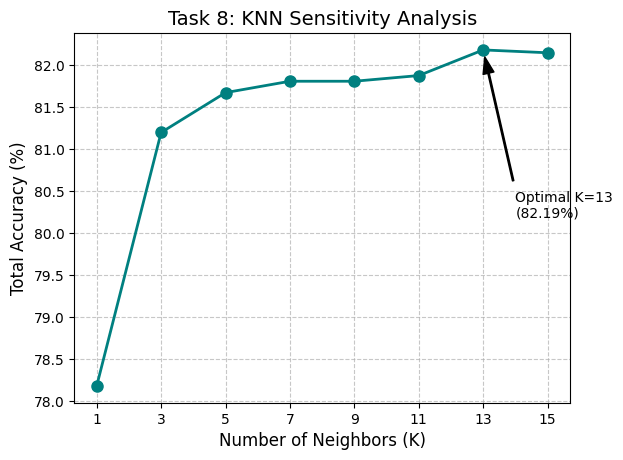

In [30]:
# Plot K vs Accuracy

def plot_k_sensitivity(k_values, accuracies):
    
    plt.plot(k_values, accuracies, marker='o', linestyle='-', color='teal', linewidth=2, markersize=8)
    
    plt.title('Task 8: KNN Sensitivity Analysis', fontsize=14)
    plt.xlabel('Number of Neighbors (K)', fontsize=12)
    plt.ylabel('Total Accuracy (%)', fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(k_values)
    
    best_acc = max(accuracies)
    best_k = k_values[accuracies.index(best_acc)]
    plt.annotate(f'Optimal K={best_k}\n({best_acc:.2f}%)', 
                 xy=(best_k, best_acc), 
                 xytext=(best_k + 1, best_acc - 2),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

    plt.savefig('Task8_knn_k_sensitivity.png', bbox_inches='tight')
    print("Plot saved as 'Task8_knn_k_sensitivity.png'")

plot_k_sensitivity(k_values, k_results)